In [25]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [26]:
DATA_DIR = "../botify/data/"

In [27]:
data = pd.read_json(DATA_DIR + "data_large.json", lines=True)

In [28]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [29]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

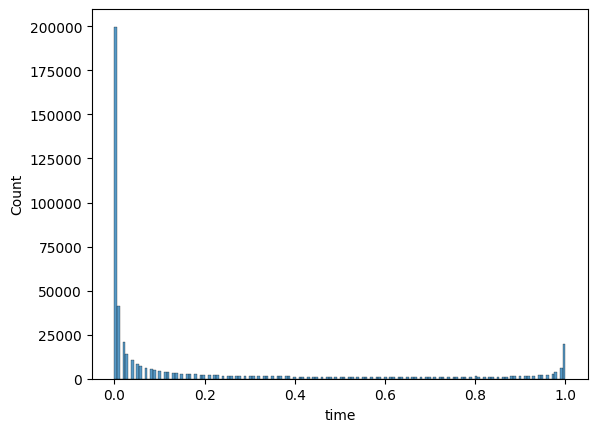

In [30]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [31]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(385303, 47699, 48077)

In [32]:
features = ["start", "track"]

In [33]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(50000, embedding_dim)
        self.track = nn.Embedding(50000, embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0])
        track = self.track(x[:, 1])
        return torch.sum(context * track, dim=1)
            
    
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [34]:
train_dataset = td.TensorDataset(
    torch.from_numpy(train_data[features].values), 
    torch.from_numpy(train_data["time"].values)
)

val_dataset = td.TensorDataset(
    torch.from_numpy(val_data[features].values), 
    torch.from_numpy(val_data["time"].values)
)

In [35]:
net = ContextualRanker()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [36]:
trainer.fit(
    net, 
    td.DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=0),
    td.DataLoader(val_dataset, batch_size=2048, num_workers=0)
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | context | Embedding | 500 K 
1 | track   | Embedding | 500 K 
--------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.000     Total estimated model params size (MB)


Sanity Checking:   0%|                                                                                                             | 0/2 [00:00<?, ?it/s]

D:\Programs\Miniconda\envs\test3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


D:\Programs\Miniconda\envs\test3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.76it/s, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.94it/s, v_num=1, val_loss=8.910]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:10<00:00, 17.50it/s, v_num=1, val_loss=8.170]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.66it/s, v_num=1, val_loss=7.510]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  75%|████████████████████████████████████████████████████████████████████▎                      | 18/24 [00:00<00:00, 23.95it/s]


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 23.54it/s, v_num=1, val_loss=6.920]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.07it/s, v_num=1, val_loss=6.400]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.37it/s, v_num=1, val_loss=5.920]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.80it/s, v_num=1, val_loss=5.490]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  50%|█████████████████████████████████████████████▌                                             | 12/24 [00:00<00:00, 23.28it/s]


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.91it/s, v_num=1, val_loss=5.100]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.72it/s, v_num=1, val_loss=4.740]
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.10it/s, v_num=1, val_loss=4.410]
Validation: 0it [00:00, ?it/s]
Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:10<00:00, 18.74it/s, v_num=1, val_loss=4.110]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  25%|███████████████████████                                                                     | 6/24 [00:00<00:00, 22.06it/s]


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:10<00:00, 18.58it/s, v_num=1, val_loss=3.840]
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.23it/s, v_num=1, val_loss=3.580]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.84it/s, v_num=1, val_loss=3.340]
Validation: 0it [00:00, ?it/s]
Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.30it/s, v_num=1, val_loss=3.130]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                                                    | 0/24 [00:00<?, ?it/s]


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.17it/s, v_num=1, val_loss=2.920]
Validation: 0it [00:00, ?it/s]
Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.82it/s, v_num=1, val_loss=2.730]
Validation: 0it [00:00, ?it/s]
Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.87it/s, v_num=1, val_loss=2.560]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|███████████████████████████████████████████████████████████████████████████████▋           | 21/24 [00:00<00:00, 28.13it/s]


Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.63it/s, v_num=1, val_loss=2.390]
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:11<00:00, 16.40it/s, v_num=1, val_loss=2.240]
Validation: 0it [00:00, ?it/s]
Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:16<00:00, 11.48it/s, v_num=1, val_loss=2.090]
Validation: 0it [00:00, ?it/s]
Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 19.48it/s, v_num=1, val_loss=1.960]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  62%|████████████████████████████████████████████████████████▉                                  | 15/24 [00:00<00:00, 22.57it/s]


Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 20.31it/s, v_num=1, val_loss=1.830]
Validation: 0it [00:00, ?it/s]
Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:10<00:00, 18.38it/s, v_num=1, val_loss=1.720]
Validation: 0it [00:00, ?it/s]
Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 20.81it/s, v_num=1, val_loss=1.600]
Validation: 0it [00:00, ?it/s]
Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 19.40it/s, v_num=1, val_loss=1.500]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  38%|██████████████████████████████████▌                                                         | 9/24 [00:00<00:00, 24.66it/s]


Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 19.92it/s, v_num=1, val_loss=1.400]
Validation: 0it [00:00, ?it/s]
Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.80it/s, v_num=1, val_loss=1.310]
Validation: 0it [00:00, ?it/s]
Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:13<00:00, 13.59it/s, v_num=1, val_loss=1.220]
Validation: 0it [00:00, ?it/s]
Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 20.74it/s, v_num=1, val_loss=1.140]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███████████▌                                                                                | 3/24 [00:00<00:00, 30.00it/s]


Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.46it/s, v_num=1, val_loss=1.070]
Validation: 0it [00:00, ?it/s]
Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 20.86it/s, v_num=1, val_loss=0.995]
Validation: 0it [00:00, ?it/s]
Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 23.47it/s, v_num=1, val_loss=0.929]
Validation: 0it [00:00, ?it/s]
Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 20.86it/s, v_num=1, val_loss=0.866]


Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.59it/s, v_num=1, val_loss=0.866]
Validation: 0it [00:00, ?it/s]
Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 23.17it/s, v_num=1, val_loss=0.807]
Validation: 0it [00:00, ?it/s]
Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.40it/s, v_num=1, val_loss=0.752]
Validation: 0it [00:00, ?it/s]
Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.98it/s, v_num=1, val_loss=0.701]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  75%|████████████████████████████████████████████████████████████████████▎                      | 18/24 [00:00<00:00, 25.71it/s]


Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:13<00:00, 13.53it/s, v_num=1, val_loss=0.653]
Validation: 0it [00:00, ?it/s]
Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.90it/s, v_num=1, val_loss=0.609]
Validation: 0it [00:00, ?it/s]
Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.31it/s, v_num=1, val_loss=0.567]
Validation: 0it [00:00, ?it/s]
Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.25it/s, v_num=1, val_loss=0.529]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  50%|█████████████████████████████████████████████▌                                             | 12/24 [00:00<00:00, 31.49it/s]


Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.36it/s, v_num=1, val_loss=0.493]
Validation: 0it [00:00, ?it/s]
Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.59it/s, v_num=1, val_loss=0.460]
Validation: 0it [00:00, ?it/s]
Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.52it/s, v_num=1, val_loss=0.430]
Validation: 0it [00:00, ?it/s]
Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.52it/s, v_num=1, val_loss=0.402]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  25%|███████████████████████                                                                     | 6/24 [00:00<00:00, 28.83it/s]


Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.74it/s, v_num=1, val_loss=0.376]
Validation: 0it [00:00, ?it/s]
Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.77it/s, v_num=1, val_loss=0.353]
Validation: 0it [00:00, ?it/s]
Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:10<00:00, 17.57it/s, v_num=1, val_loss=0.331]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.28it/s, v_num=1, val_loss=0.312]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                                                    | 0/24 [00:00<?, ?it/s]


Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.64it/s, v_num=1, val_loss=0.294]
Validation: 0it [00:00, ?it/s]
Epoch 51: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.79it/s, v_num=1, val_loss=0.278]
Validation: 0it [00:00, ?it/s]
Epoch 52: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.93it/s, v_num=1, val_loss=0.263]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|███████████████████████████████████████████████████████████████████████████████▋           | 21/24 [00:00<00:00, 27.50it/s]


Epoch 53: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.77it/s, v_num=1, val_loss=0.250]
Validation: 0it [00:00, ?it/s]
Epoch 54: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.32it/s, v_num=1, val_loss=0.238]
Validation: 0it [00:00, ?it/s]
Epoch 55: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.86it/s, v_num=1, val_loss=0.228]
Validation: 0it [00:00, ?it/s]
Epoch 56: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.77it/s, v_num=1, val_loss=0.218]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  62%|████████████████████████████████████████████████████████▉                                  | 15/24 [00:00<00:00, 30.96it/s]


Epoch 57: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.82it/s, v_num=1, val_loss=0.210]
Validation: 0it [00:00, ?it/s]
Epoch 58: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 20.81it/s, v_num=1, val_loss=0.202]
Validation: 0it [00:00, ?it/s]
Epoch 59: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 21.91it/s, v_num=1, val_loss=0.195]
Validation: 0it [00:00, ?it/s]
Epoch 60: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.55it/s, v_num=1, val_loss=0.189]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  38%|██████████████████████████████████▌                                                         | 9/24 [00:00<00:00, 30.66it/s]


Epoch 61: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.64it/s, v_num=1, val_loss=0.184]
Validation: 0it [00:00, ?it/s]
Epoch 62: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.32it/s, v_num=1, val_loss=0.179]
Validation: 0it [00:00, ?it/s]
Epoch 63: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.70it/s, v_num=1, val_loss=0.174]
Validation: 0it [00:00, ?it/s]
Epoch 64: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.65it/s, v_num=1, val_loss=0.170]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███████████▌                                                                                | 3/24 [00:00<00:00, 29.28it/s]


Epoch 65: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.97it/s, v_num=1, val_loss=0.166]
Validation: 0it [00:00, ?it/s]
Epoch 66: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.80it/s, v_num=1, val_loss=0.163]
Validation: 0it [00:00, ?it/s]
Epoch 67: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 23.51it/s, v_num=1, val_loss=0.159]
Validation: 0it [00:00, ?it/s]
Epoch 67: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 21.00it/s, v_num=1, val_loss=0.156]


Epoch 68: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 21.86it/s, v_num=1, val_loss=0.156]
Validation: 0it [00:00, ?it/s]
Epoch 69: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:10<00:00, 18.26it/s, v_num=1, val_loss=0.153]
Validation: 0it [00:00, ?it/s]
Epoch 70: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.54it/s, v_num=1, val_loss=0.151]
Validation: 0it [00:00, ?it/s]
Epoch 71: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.35it/s, v_num=1, val_loss=0.148]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  75%|████████████████████████████████████████████████████████████████████▎                      | 18/24 [00:00<00:00, 32.03it/s]


Epoch 72: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.11it/s, v_num=1, val_loss=0.146]
Validation: 0it [00:00, ?it/s]
Epoch 73: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.88it/s, v_num=1, val_loss=0.144]
Validation: 0it [00:00, ?it/s]
Epoch 74: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.88it/s, v_num=1, val_loss=0.142]
Validation: 0it [00:00, ?it/s]
Epoch 75: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.92it/s, v_num=1, val_loss=0.140]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  50%|█████████████████████████████████████████████▌                                             | 12/24 [00:00<00:00, 31.78it/s]


Epoch 76: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.60it/s, v_num=1, val_loss=0.139]
Validation: 0it [00:00, ?it/s]
Epoch 77: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.74it/s, v_num=1, val_loss=0.137]
Validation: 0it [00:00, ?it/s]
Epoch 78: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.15it/s, v_num=1, val_loss=0.136]
Validation: 0it [00:00, ?it/s]
Epoch 79: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 19.21it/s, v_num=1, val_loss=0.135]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  25%|███████████████████████                                                                     | 6/24 [00:00<00:00, 28.78it/s]


Epoch 80: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.50it/s, v_num=1, val_loss=0.134]
Validation: 0it [00:00, ?it/s]
Epoch 81: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.30it/s, v_num=1, val_loss=0.133]
Validation: 0it [00:00, ?it/s]
Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.60it/s, v_num=1, val_loss=0.132]
Validation: 0it [00:00, ?it/s]
Epoch 83: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.64it/s, v_num=1, val_loss=0.131]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                                                    | 0/24 [00:00<?, ?it/s]


Epoch 84: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.85it/s, v_num=1, val_loss=0.131]
Validation: 0it [00:00, ?it/s]
Epoch 85: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.33it/s, v_num=1, val_loss=0.130]
Validation: 0it [00:00, ?it/s]
Epoch 86: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.03it/s, v_num=1, val_loss=0.129]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|███████████████████████████████████████████████████████████████████████████████▋           | 21/24 [00:00<00:00, 27.37it/s]


Epoch 87: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.71it/s, v_num=1, val_loss=0.129]
Validation: 0it [00:00, ?it/s]
Epoch 88: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.65it/s, v_num=1, val_loss=0.128]
Validation: 0it [00:00, ?it/s]
Epoch 89: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:12<00:00, 15.49it/s, v_num=1, val_loss=0.128]
Validation: 0it [00:00, ?it/s]
Epoch 90: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 23.01it/s, v_num=1, val_loss=0.127]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  62%|████████████████████████████████████████████████████████▉                                  | 15/24 [00:00<00:00, 27.23it/s]


Epoch 91: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.09it/s, v_num=1, val_loss=0.127]
Validation: 0it [00:00, ?it/s]
Epoch 92: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 23.01it/s, v_num=1, val_loss=0.127]
Validation: 0it [00:00, ?it/s]
Epoch 93: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.75it/s, v_num=1, val_loss=0.126]
Validation: 0it [00:00, ?it/s]
Epoch 94: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 23.88it/s, v_num=1, val_loss=0.126]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  38%|██████████████████████████████████▌                                                         | 9/24 [00:00<00:00, 23.22it/s]


Epoch 95: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 23.31it/s, v_num=1, val_loss=0.126]
Validation: 0it [00:00, ?it/s]
Epoch 96: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 20.80it/s, v_num=1, val_loss=0.126]
Validation: 0it [00:00, ?it/s]
Epoch 97: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 23.17it/s, v_num=1, val_loss=0.125]
Validation: 0it [00:00, ?it/s]
Epoch 98: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 19.59it/s, v_num=1, val_loss=0.125]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███████████▌                                                                                | 3/24 [00:00<00:00, 21.20it/s]


Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 20.83it/s, v_num=1, val_loss=0.125]
Validation: 0it [00:00, ?it/s]
Epoch 100: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.37it/s, v_num=1, val_loss=0.125]
Validation: 0it [00:00, ?it/s]
Epoch 101: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.06it/s, v_num=1, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Epoch 101: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.39it/s, v_num=1, val_loss=0.124]


Epoch 102: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 20.45it/s, v_num=1, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Epoch 103: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 21.86it/s, v_num=1, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Epoch 104: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 21.57it/s, v_num=1, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Epoch 105: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.55it/s, v_num=1, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  75%|████████████████████████████████████████████████████████████████████▎                      | 18/24 [00:00<00:00, 29.72it/s]


Epoch 106: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.63it/s, v_num=1, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Epoch 107: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.59it/s, v_num=1, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Epoch 108: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 21.45it/s, v_num=1, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Epoch 109: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:10<00:00, 17.64it/s, v_num=1, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  50%|█████████████████████████████████████████████▌                                             | 12/24 [00:00<00:00, 14.90it/s]


Epoch 110: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 19.01it/s, v_num=1, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Epoch 111: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 21.67it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 112: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 23.46it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 113: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.32it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  25%|███████████████████████                                                                     | 6/24 [00:00<00:00, 29.66it/s]


Epoch 114: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.17it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 115: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 21.49it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 116: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.77it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 117: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.71it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                                                    | 0/24 [00:00<?, ?it/s]


Epoch 118: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 19.75it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 119: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 19.54it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 120: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.64it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|███████████████████████████████████████████████████████████████████████████████▋           | 21/24 [00:00<00:00, 25.32it/s]


Epoch 121: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.84it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 122: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:09<00:00, 20.55it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 123: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.23it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 124: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.55it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  62%|████████████████████████████████████████████████████████▉                                  | 15/24 [00:00<00:00, 30.50it/s]


Epoch 125: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.22it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 126: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.18it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 127: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.74it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 128: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.26it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  38%|██████████████████████████████████▌                                                         | 9/24 [00:00<00:00, 19.23it/s]


Epoch 129: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.08it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 130: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.21it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 131: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.40it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 132: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.95it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███████████▌                                                                                | 3/24 [00:00<00:00, 26.32it/s]


Epoch 133: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.03it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 134: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.83it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 135: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.67it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 135: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.88it/s, v_num=1, val_loss=0.123]


Epoch 136: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.52it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 137: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.41it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 138: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.08it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 139: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:10<00:00, 18.54it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  75%|████████████████████████████████████████████████████████████████████▎                      | 18/24 [00:00<00:00, 30.95it/s]


Epoch 140: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 22.28it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 141: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.72it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 142: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.92it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 143: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.55it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  50%|█████████████████████████████████████████████▌                                             | 12/24 [00:00<00:00, 33.00it/s]


Epoch 144: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 26.23it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 145: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 25.88it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 146: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:07<00:00, 24.65it/s, v_num=1, val_loss=0.123]
Validation: 0it [00:00, ?it/s]
Epoch 146: 100%|██████████████████████████████████████████████████████████████████████████████| 189/189 [00:08<00:00, 21.95it/s, v_num=1, val_loss=0.123]


In [37]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path)

In [38]:
test_loader = td.DataLoader(torch.from_numpy(test_data[features].values), batch_size=512, shuffle=False, num_workers=0)

nn_predictions = []
for batch in tqdm.tqdm(test_loader, total=test_data.shape[0] / 512):
    nn_predictions.extend(best(batch).detach().numpy().tolist())

 61%|███████████████████████████████████████████████████████████████▋                                         | 57/93.900390625 [00:00<00:00, 282.49it/s]D:\Programs\Miniconda\envs\test3\lib\site-packages\tqdm\std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/93.900390625 [00:00<00:00, 319.72it/s]


In [39]:
eval_data = test_data.copy().assign(nn = nn_predictions).assign(rdm = np.random.random(len(test_data))).assign(avg = train_data["time"].mean()).head()

In [40]:
sm.mean_squared_error(eval_data["nn"], eval_data["time"])

0.00012043253707234806

In [41]:
sm.mean_squared_error(eval_data["rdm"], eval_data["time"])

0.29014003687055695

In [42]:
sm.mean_squared_error(eval_data["avg"], eval_data["time"])

0.03938183558739121

## Compute top recommendations

In [43]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)

In [44]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [45]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [46]:
k = 10
with open(DATA_DIR + "homework_recommendations.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

50000it [02:25, 343.04it/s]


In [47]:
track = 1982
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

,artist,title
1982,Rammstein,Engel


In [48]:
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]

,artist,title
170,Charttraxx Karaoke,Fireflies
598,Octopus Project,Hypnopaedia
1083,Kid Cudi / MGMT / Ratatat,Pursuit Of Happiness (nightmare)
1090,Florence + The Machine,Cosmic Love
1113,Adam Lambert,Whataya Want From Me
1124,Yeah Yeah Yeahs,Soft Shock
1511,Skillet,Hero (Album Version)
1530,Linkin Park,In The End (Album Version)
1729,Linkin Park,New Divide (Album Version)
10032,Kings Of Leon,Be Somebody
